In [1]:
!nvidia-smi

Wed Oct  9 14:53:20 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.78       Driver Version: 410.78       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:03:00.0 Off |                  N/A |
| 36%   60C    P2   138W / 200W |   7847MiB /  8119MiB |     77%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 00000000:04:00.0 Off |                  N/A |
| 37%   58C    P2    48W / 200W |   7847MiB /  8119MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [14]:
# Necessary imports
%load_ext autoreload
%autoreload 2
import os
import sys
import logging

import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt

sys.path.append('..')
from seismiqb.batchflow import Dataset, Pipeline, FilesIndex
from seismiqb.batchflow import B, V, C, L, F, D, P, R, W
from seismiqb.batchflow.models.tf import DenseNetFC, TFModel
from seismiqb.batchflow.models.tf.layers import conv_block
from seismiqb import SeismicCropBatch, SeismicGeometry, SeismicCubeset, plot_loss
from seismiqb.batchflow import FilesIndex, Batch, action, inbatch_parallel
from seismiqb.batchflow.batch_image import transform_actions # pylint: disable=no-name-in-module,import-error
from seismiqb.src.utils import create_mask, aggregate, make_labels_dict, _get_horizons
from seismiqb.src.utils import _get_horizons, compare_horizons, dump_horizon, round_to_array, convert_to_numba_dict
# from utils import *

from glob import glob
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%env CUDA_VISIBLE_DEVICES=4

env: CUDA_VISIBLE_DEVICES=4


In [4]:
# def create_predict_ppl(model_pipeline, crops_gen_name, crop_shape, axes):
#     pred_pipeline = (Pipeline()
#                          .load_component(src=[D('geometries'), D('labels')],
#                                          dst=['geometries', 'labels'])
#                          .add_components('predicted_labels')
#                          .crop(points=L(D(crops_gen_name)),
#                                shape=crop_shape, passdown='predicted_labels')
#                          .load_component(src=[D('prior_mask')], dst=['predicted_labels'])
#                          .load_cubes(dst='images')
#                          .create_masks(dst='masks', width=1, n_horizons=1, src_labels='labels')
#                          .create_masks(dst='cut_masks', width=1, n_horizons=1, src_labels='predicted_labels')
#                          .apply_transform(np.transpose, axes=axes, src=['images', 'masks', 'cut_masks'])
#                          .rotate_axes(src=['images', 'masks', 'cut_masks'])
#                          .scale(mode='normalize', src='images')
#                          .import_model('extension', model_pipeline)
#                          .init_variable('result_preds', default=list())
#                          .concat_components(src=('images', 'cut_masks'), dst='model_inputs')
#                          .predict_model('extension', fetches='sigmoid',
#                                           images=B('model_inputs'),
#                                           cut_masks=B('cut_masks'),
#                                           save_to=V('result_preds', mode='e')))
#     return pred_pipeline

# def predict_direction(ds, model_pipeline, dst, direction):
#     grid_info = getattr(ds, direction + '_crops_info')
#     n_iters = getattr(ds, direction + '_crops_iters')
#     order = (2, 0, 1) if direction == 'xline' else (0, 2, 1)
#     axes = (0, 1, 2) if direction == 'xline' else (1, 0, 2)

#     crops_gen_name = direction + '_crops_gen'

#     predict_ppl = create_predict_ppl(model_pipeline, crops_gen_name, grid_info['crop_shape'], axes=axes) << ds
    
#     for i in range(n_iters):
#         pred_batch = predict_ppl.next_batch(1, n_epochs=None)    

#     assemble_ppl = Pipeline().assemble_crops(src=predict_ppl.v("result_preds"), dst='assembled_pred',
#                                              grid_info=grid_info, order=order) << ds
#     btch = assemble_ppl.next_batch(1)
#     points = [rng[0] for rng in grid_info['range']]
#     transforms = [lambda i_: ds.geometries[ds.indices[0]].ilines[i_ + points[0]],
#                         lambda x_: ds.geometries[ds.indices[0]].xlines[x_ + points[1]],
#                         lambda h_: h_ + points[2]]
    
#     ds.get_point_cloud(btch.assembled_pred, threshold=0.001, dst=dst,
#                        coordinates=None, separate=True, transforms=transforms)
#     merged_dict = {**getattr(ds, dst)[0], **getattr(ds, dst)[1]}
#     setattr(ds, dst, {ds.indices[0]: convert_to_numba_dict(merged_dict)})
    
# def extension_step(ds, img, model_pipeline, crop_shape=(4, 100, 100)):
# #     img = ds.show_labels(return_image=True, src='prior_mask', show_plot=False)
#     ds = ds.make_expand_grid(ds.indices[0], crop_shape=crop_shape,
#                             labels_img=img, labels_idx=1)
#     predict_direction(ds, model_pipeline, 'predicted_mask_x', 'xline')
#     predict_direction(ds, model_pipeline, 'predicted_mask_iline', 'iline')

#     expanded_labels = {**ds.predicted_mask_x[ds.indices[0]], **ds.predicted_mask_iline[ds.indices[0]], **ds.prior_mask[ds.indices[0]]}
#     setattr(ds, 'prior_mask', {ds.indices[0]: convert_to_numba_dict(expanded_labels)})
    
# def expand_cycle(ds, crop_shape=(4, 100, 100)):
#     model_pipeline = (Pipeline().load_model('static', TFModel, 'extension', path='./weighted_dice_r_cube/') << ds)
#     model_pipeline.next_batch(1)

#     for i in range(10):
#         img = ds.show_labels(return_image=True, src='prior_mask')
#         extension_step(ds, img, model_pipeline, crop_shape=crop_shape)

In [5]:
paths_cubes = ['/notebooks/SEISMIC_DATA/CUBE_3/P_cube__copy.hdf5']

dsi = FilesIndex(path=paths_cubes, no_ext=True)
ds = SeismicCubeset(dsi)
ds = ds.load()

In [6]:
p_start_points = [1709, 1253, 527]
ds.labels[ds.indices[0]][(1709 + ds.geometries[ds.indices[0]].ilines_offset, 1253 + ds.geometries[ds.indices[0]].xlines_offset)]

array([1148,  564,  889, 1170, 1170])

hey you


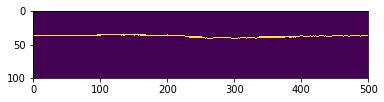

In [7]:
ds.subset_labels(p_start_points, crop_shape=[500, 500, 100], cube_index=0, show_prior_mask=True)

In [8]:
ds.indices[0]

'P_cube__copy'

INFO:tensorflow:Restoring parameters from ./weighted_dice_r_cube/model-2001
len  250000


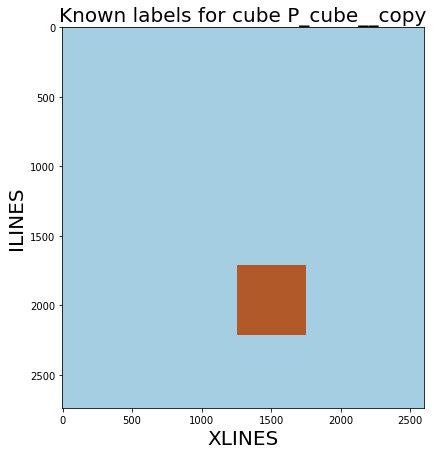

len  287713


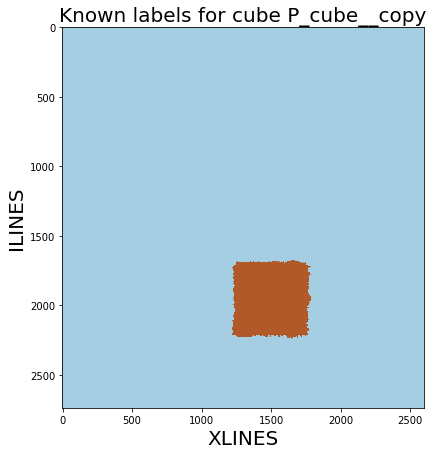

In [ ]:
ds.expand_cycle(ds.indices[0], crop_shape=(4, 100, 100), path='./weighted_dice_r_cube/', return_image=True, n_iters=10)

In [ ]:
# expand_cycle(ds, crop_shape=(4, 100, 100))

In [8]:
a = np.zeros((20, 10, 2))

In [18]:
slc = [slice(0, 5), slice(0, 4), slice(None, None)]

In [19]:
a[slc].shape

(5, 4, 2)